<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-runs" data-toc-modified-id="Test-runs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test runs</a></span></li><li><span><a href="#Interact" data-toc-modified-id="Interact-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interact</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.cell_models import cell_v1

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed, interact_manual

from statsmodels.tsa.stattools import acf

from scipy.signal import find_peaks

Notes: 
- concentration threshold for division: it looks very sensitive to the growth rate. Not sure there is a limit cycle in general to this problem. Can you sketch it? 
- amount threshold for division: a quick look at the RB amount threshold seems to indicate that it can yield limit cycles... ? 

# Test runs

Build something with interact so that you can get a rough sense of how the system behaves. 

In [29]:
def plot1(ax, cell):
    """
    """
    ax.plot(np.array(cell.M_hist)/cell.M_hist[0], label="M")
    ax.plot(np.array(cell.RB_hist)/cell.RB_hist[0], label="RB")
    ax.plot(np.array(cell.RB_c_hist)/cell.RB_c_hist[0], label="[RB]")

    phase_vec = np.array([int(phase=="G1") for phase in cell.phase_hist])
    x_min = 0
    x_max = len(phase_vec)

    phase=0
    for k in range(len(phase_vec)):
        if (phase_vec[k]==1) and phase==0:
            x_min = k
            phase=1
        elif (phase_vec[k]==0) and phase==1:
            x_max=k-1
            phase=0
            ax.axvspan(x_min, x_max, color = 'lightgray', alpha=.3)

    if x_min > x_max:
        ax.axvspan(x_min, len(phase_vec), color = 'lightgray', alpha=.3)
    
    ax.set_yscale('log')
#     ax[0,0].axhline(cell.RB_transition/cell.RB_c_hist[0], color="red")
#     ax[0,0].axhline(cell.RB_division/cell.RB_c_hist[0], color="gray")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Variables")

In [30]:
def plot2(ax, cell):
    """
    """
    ax.plot(cell.M_hist, cell.RB_hist, alpha=.5)
#     ax.axhline(cell.RB_division, color='red')
#     m_vec = np.linspace(0, 2)
#     ax.plot(m_vec, m_vec*cell.RB_transition, color='red')
    ax.set_xlabel("M")
    ax.set_ylabel("RB amount")
    ax.grid()

In [31]:
def plot3(ax, cell):
    """
    """
    ax.scatter(
        np.array(cell.M_hist)[phase_vec==1], 
        np.array(cell.RB_c_hist)[phase_vec==1], 
        alpha=.3, s=1, label="G1"
    )
    ax.scatter(
        np.array(cell.M_hist)[phase_vec==0], 
        np.array(cell.RB_c_hist)[phase_vec==0], 
        alpha=.3, s=1, label="G2"
    )
    ax.grid()
    ax.set_xlabel("M")
    ax.set_ylabel("[RB]")
    ax.legend()

In [32]:
def run_and_plot_test(
    alpha=2, beta0=3, delta=1, 
    gamma=.9, epsilon=.01, dt=1e-3, 
    division="timer", transition="size", 
    time_SG2=1e-1, transition_th=1.
):
    
    cell = cell_v1(
        alpha=alpha, beta0=beta0, delta=delta, 
        gamma=gamma, epsilon=epsilon, dt=dt, 
        division=division, transition=transition, 
        time_SG2=time_SG2, transition_th=transition_th
    )
    
    T = 5000

    for _ in range(T):
        cell.grow()
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    t_vec = np.arange(T+1)

    plot1(ax[0,0], cell)
    plot2(ax[0,1], cell)
    plot3(ax[1,0], cell)
#     plot4(ax[1,1], cell)
    
    
    
    nlags=4000
    acf_RB = acf(cell.RB_hist, fft=False, nlags=nlags)
    acf_M = acf(cell.M_hist, fft=False, nlags=nlags)
    acf_RBc = acf(cell.RB_c_hist, fft=False, nlags=nlags)
    labels = ["RB", "M", "[RB]"]
    peaks_all = []
    dists_peaks = []
    for i, acf_ in enumerate([acf_RB, acf_M, acf_RBc]):
        peaks, _ = find_peaks(acf_, height=None, prominence=.1)
        ax[1,1].plot(acf_, label=labels[i])
        ax[1,1].plot(peaks, acf_[peaks], "x", color="grey", ms=10, linewidth=3)
        peaks_all.append(peaks)
        dists_peaks.append([peaks[i+1]-peaks[i] for i in range(len(peaks)-1)])
        
    ax[1,1].grid()
    ax[1,1].set_xlabel("Lag")
    ax[1,1].set_ylabel("ACF")
    ax[1,1].legend()
    
    pc_th = .1

    mean_dists = [np.mean(d) for d in dists_peaks]
    std_dists = [np.std(d) for d in dists_peaks]

    periodic = (np.std(mean_dists)/np.mean(mean_dists) < pc_th) and (all(np.divide(std_dists, mean_dists) < pc_th))

    if periodic: 
        period = np.mean(mean_dists)
        print(f"   Periodic with period {period}.")
    else:
        period = None
        print(f"   Non periodic.")
        
    
    
    return cell, dists_peaks, period

In [33]:
step=.1

Params check not implemented


NameError: name 'phase_vec' is not defined

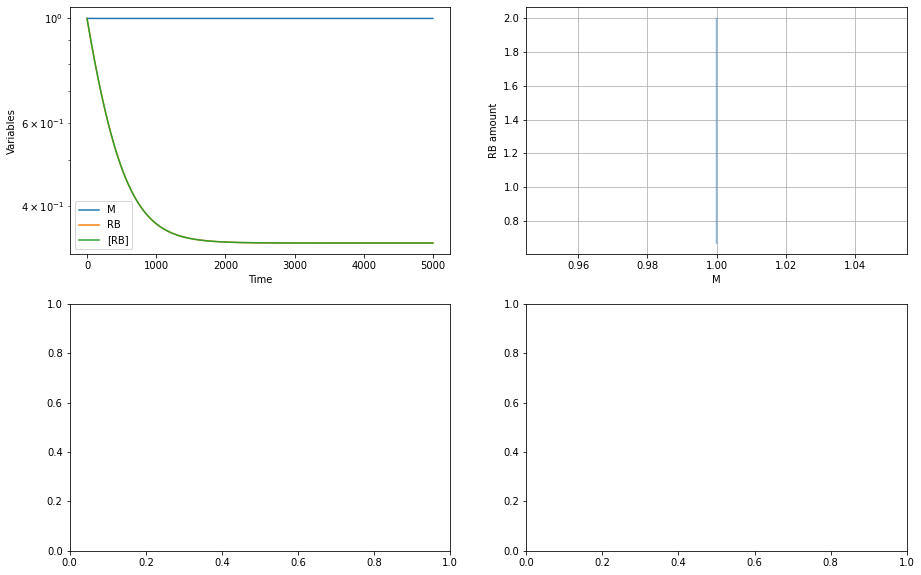

In [34]:
cell_test, dists_peaks, period = run_and_plot_test()

# Interact

In [ ]:
interact_manual(
    run_and_plot_test, 
    alpha=(.1, 10., step), beta0=(.1, 10, step), epsilon=(.1, 1., step), 
    delta=fixed(1.), gamma=(.1, 1), RB_thresh=(.1, 10, step),
    division=["concentration", "amount"], dt=fixed(1e-3), 
    continuous_update=False
);